# Setup
Load the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10) 

filenames = 'data/run{}.csv'
datasets = []
for i in range(5):
    data = np.genfromtxt(filenames.format(i), delimiter=', ', comments='#')
    # first line is always header
    data = data[1:]
    datasets.append(data)

# Inspect the data
Currently there are 5 runs, but one had a channel failing and on the last one I changed the electrode pins so we will see if this is useful at all. thus first we take a look at the data from all runs quickly to visually inspect what we have:

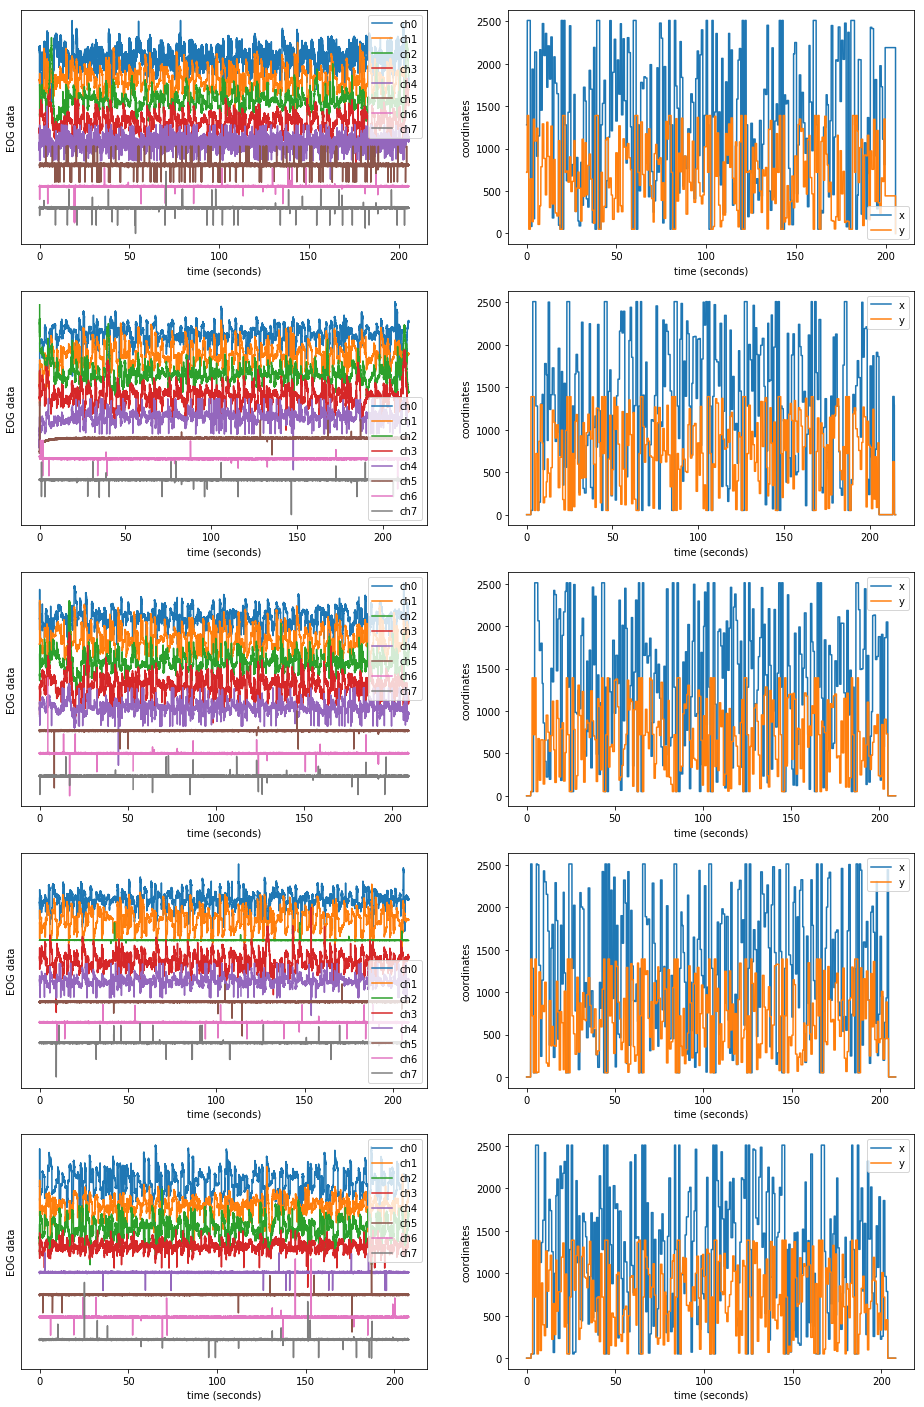

In [2]:
plt.figure(figsize=(16, 25))
for i, data in enumerate(datasets):
    raw_times = data[:, 0].copy()
    eog = data[:, 1:9].copy()
    coords = data[:, 9:].copy()

    times = (raw_times - raw_times[0])
    threshold = 1000
    eog[np.abs(eog) > threshold] = np.nan
    
    plt.subplot(5, 2, 2*i+1)
    offset = 300
    for ch in range(8):
        plt.plot(times, eog[:,ch] - ch*offset, label='ch{}'.format(ch))
    plt.legend()
    plt.xlabel('time (seconds)')
    plt.yticks([], [])
    plt.ylabel('EOG data')
    
    plt.subplot(5, 2, 2*i+2)
    coordnames = ['x', 'y']
    for c in range(2):
        plt.plot(times, coords[:, c], label=coordnames[c])
    plt.legend()
    plt.xlabel('time (seconds)')
    plt.ylabel('coordinates')
    
    

# Channel failure
Clearly the first three runs are good, we have two noisy channels at the start and end and three good channels for the comparisons between the 4 electrodes in the middle.

* In the fourth run, the middle channel failed, which is unfortunate, because this is the data for vertical eye-movement.

* In the fifth channel I moves the electrodes all one pin further on the board. Still there is data missing now.

I will omit runs 4 and 5 for now and only work with runs 1-3. Probably record more data later, when I have a first idea on how the analysis will work in the end.

# More weird behavior
The next day I tried again to record some more data and see, whether the problem still exists. Here there were wird artifacts in the data, where some channels would shift somehow over time and again the middle channel was missing. Here is a short example recording to show the weird behavior:

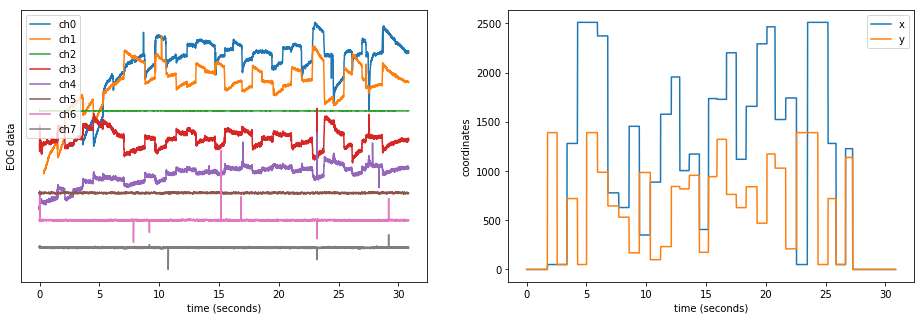

In [3]:
plt.figure(figsize=(16, 5))
weirddata = np.genfromtxt('data/weird_problem.csv', delimiter=', ', comments='#')
weirddata = weirddata[1:, :]
raw_times = weirddata[:, 0].copy()
eog = weirddata[:, 1:9].copy()
coords = weirddata[:, 9:].copy()

times = (raw_times - raw_times[0])
threshold = 1000
eog[np.abs(eog) > threshold] = np.nan

plt.subplot(1, 2, 1)
offset = 300
for ch in range(8):
    plt.plot(times, eog[:,ch] - ch*offset, label='ch{}'.format(ch))
plt.legend()
plt.xlabel('time (seconds)')
plt.yticks([], [])
plt.ylabel('EOG data')

plt.subplot(1, 2, 2)
coordnames = ['x', 'y']
for c in range(2):
    plt.plot(times, coords[:, c], label=coordnames[c])
plt.legend()
plt.xlabel('time (seconds)')
plt.ylabel('coordinates')
pass

# Explanations?
Since the shift appears only at the beginning of the recording, it could be from moving the head. But still is lasted for almost ten seconds and I always made sure to keep my head still and fixate my eyes on the center of the screen before the recording started.

Anyways, we have again the missing channel in the middle.

# Continuing...
Let's move on with recordings 1-3 and inspect more of the data. Also we only need channels 1-3.

In [4]:
valid_datasets = [data[:, (0, 2, 3, 4, 9, 10)] for data in datasets[:3]]
time_idx = 0
eog_idx = (1, 2, 3)
coord_idx = (4, 5)

# Point location sampling
Every run has 10 batches of 20 uniformly distributed points and 5 calibration points in the center and the four corners. That makes for a total of 600 + 150 = 750 points for analysis from the first three runs.

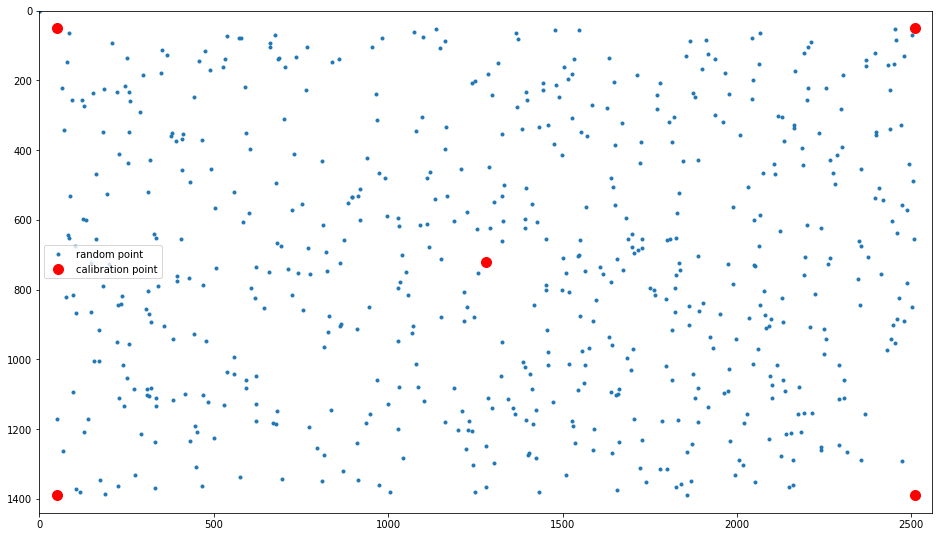

In [5]:
current = (-1,-1)
points = []

for data in valid_datasets:
    for t in range(data.shape[0]):
        point = data[t, coord_idx]
        if any(point != current):
            points.append(point)
            current = point

calibration_points = [
    (50, 50),
    (2510, 50),
    (50, 1390),
    (2510, 1390),
    (1280, 720)
]

plt.plot(*zip(*points), '.', label='random point')
plt.plot(*zip(*calibration_points), '.r', markersize=20, label='calibration point')
plt.xlim(0, 2560)
plt.ylim(1440, 0)
plt.gca().set_aspect('equal', 'box')
plt.legend()
pass

# Point interval sampling
The time between datapoints is sampled from a normal distribution around $\mu = 800ms$ with $\sigma = 100ms$. We can see the distribution of intervals here:

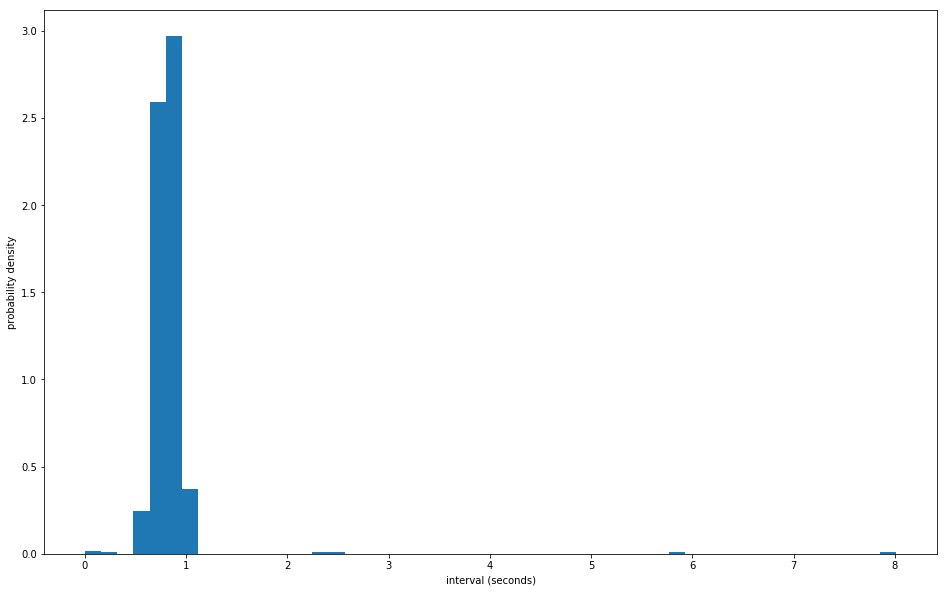

In [6]:
intervals = []
for data in valid_datasets:
    point = data[0, coord_idx]
    t1 = data[0, time_idx]
    for t in range(data.shape[0]):
        point = data[t, coord_idx]
        if any(point != current):
            t2 = data[t, time_idx]
            intervals.append(t2 - t1)
            current = point
            t1 = t2

plt.hist(intervals, bins=50, normed=True)
plt.xlabel('interval (seconds)')
plt.ylabel('probability density')
pass

This plot looks bad because we have outliers from start and end of the recordings. Let's just remove the 3 largest intervals.

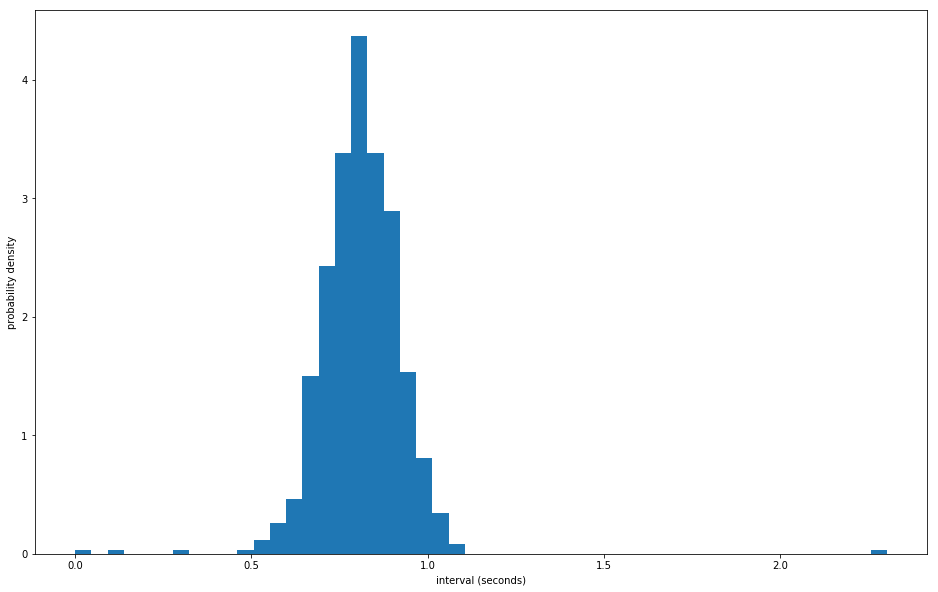

In [7]:
filtered_intervals = list(intervals)

remove_extremes = 3
for _ in range(remove_extremes):
    filtered_intervals.remove(max(filtered_intervals))
    
plt.hist(filtered_intervals, bins=50, normed=True)
plt.xlabel('interval (seconds)')
plt.ylabel('probability density')
pass

# Filtering artefacts
There are several artefacts in the data, a) spikes out of the range of EOG signals and b) drifts. Also sometimes there are only small spikes in the data. The next step will be to filter these out.

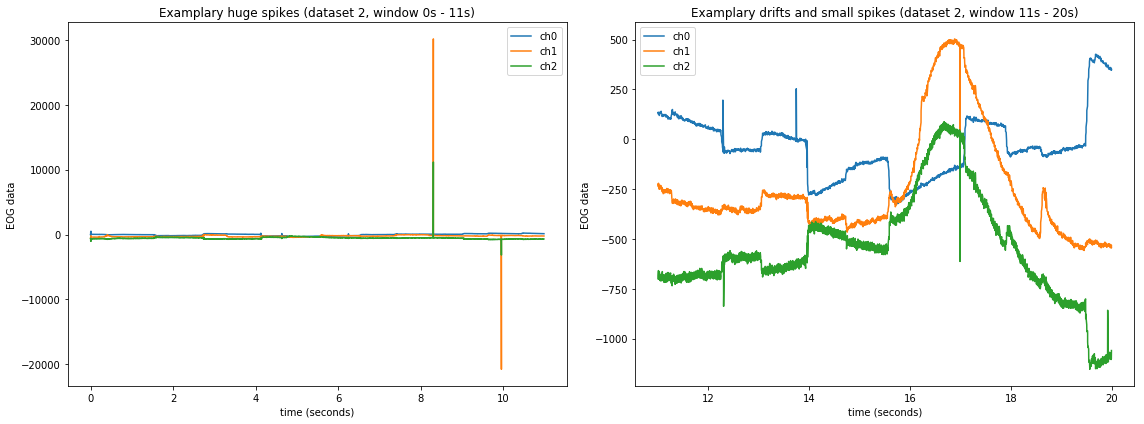

In [8]:
plt.figure(figsize=(16, 6))
data = valid_datasets[2]
raw_times = data[:, time_idx].copy()
eog = data[:, eog_idx].copy()
coords = data[:, coord_idx].copy()

times = (raw_times - raw_times[0])

offset = 300

window_times = (0, 11)
window_idxs = (window_times[0] <= times) & (times <= window_times[1])

plt.subplot(1, 2, 1)
for ch in range(3):
    plt.plot(times[window_idxs], eog[window_idxs,ch] - ch*offset, label='ch{}'.format(ch))
plt.legend()
plt.title('Examplary huge spikes (dataset 2, window 0s - 11s)')
plt.xlabel('time (seconds)')
plt.ylabel('EOG data')

window_times = (11, 20)
window_idxs = (window_times[0] < times) & (times < window_times[1])

plt.subplot(1, 2, 2)
for ch in range(3):
    plt.plot(times[window_idxs], eog[window_idxs,ch] - ch*offset, label='ch{}'.format(ch))
plt.legend()
plt.title('Examplary drifts and small spikes (dataset 2, window 11s - 20s)')
plt.xlabel('time (seconds)')
plt.ylabel('EOG data')

plt.tight_layout()

# Median Filtering
Many of the errors are actually single measurements that are somehow off. These can be easily filtered out with a median filter.

In [9]:
import scipy as sp
import scipy.signal

filtered_datasets = []
for data in valid_datasets:
    filtered_data = data.copy()
    filtered_data[:, eog_idx] = sp.signal.medfilt(data[:, eog_idx], kernel_size=(3, 1))
    filtered_datasets.append(filtered_data)

See here the same sections as above for comparison. The huge spikes can be filtered out and also most of the small ones. There are still some small spikes in the left window. Also important is that the data is a little bit denoised, but the big changes are not really affected.

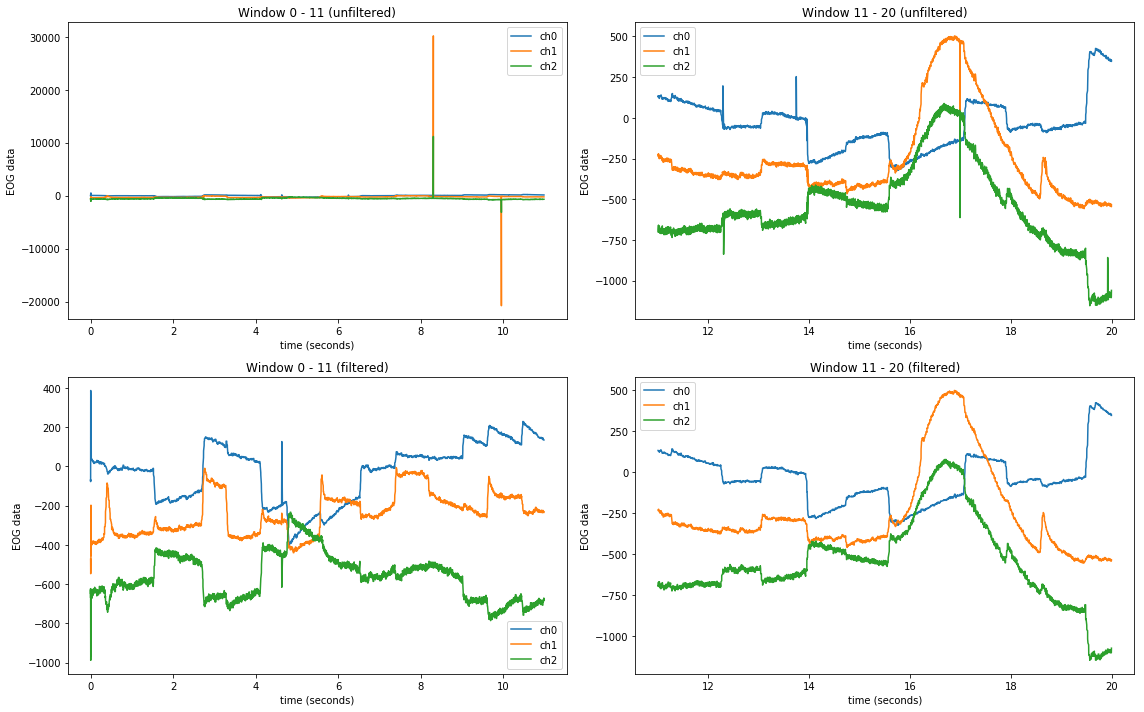

In [10]:
axes = iter(plt.subplots(2,2)[0].axes)

for data, label in ((valid_datasets[2], 'unfiltered'),
                    (filtered_datasets[2], 'filtered')):
    raw_times = data[:, time_idx].copy()
    eog = data[:, eog_idx].copy()
    coords = data[:, coord_idx].copy()

    times = (raw_times - raw_times[0])

    offset = 300
    windows_times = ((0, 11), (11, 20))
    
    for window_times in windows_times:
        
        window_idxs = (window_times[0] <= times) & (times <= window_times[1])

        plt.sca(next(axes))
        
        for ch in range(3):
            plt.plot(times[window_idxs], eog[window_idxs,ch] - ch*offset, label='ch{}'.format(ch))
        plt.legend()
        plt.title('Window {w[0]} - {w[1]} ({l})'.format(w=window_times, l=label))
        plt.xlabel('time (seconds)')
        plt.ylabel('EOG data')


plt.tight_layout()

# Finding stimulus times
A stimulus corresponds to the point on screen changing position. We need to get the indices of stimuli changes, then we can take a look at the EOG data in a window around stimuli to filter out bad ones.

In [11]:
stimulus_idxs = []
for data in filtered_datasets:
    idxs = []
    old_point = data[0, coord_idx]
    for t in range(data.shape[0]):
        new_point = data[t, coord_idx]
        if any(old_point != new_point):
            idxs.append(t)
            old_point = new_point
    stimulus_idxs.append(np.array(idxs))    

Next we can have a look at the windows around the changes:

dataset 0


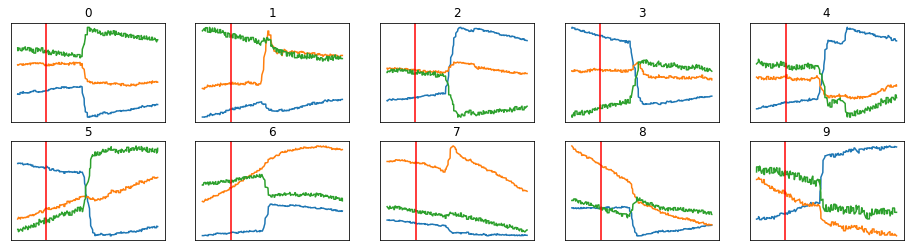

In [12]:
import math
window = (-50, 200)
# plot only first 10 stimuli from first dataset
for data_i, stim_idxs in enumerate(stimulus_idxs[:1]):
    stim_idxs = stim_idxs[:10]
    data = filtered_datasets[data_i]
    n_cols = 5
    row_size = 2
    n_rows = math.ceil(stim_idxs.shape[0]/n_cols)
    print("dataset {}".format(data_i))
    plt.figure(figsize=(16, n_rows * row_size))
    for i, stim_idx in enumerate(stim_idxs):
        eog = data[stim_idx+window[0]:stim_idx+window[1], eog_idx]
        times = data[stim_idx+window[0]:stim_idx+window[1], time_idx]
        plt.subplot(n_rows, n_cols, i+1)
        plt.plot(times, eog)
        plt.xticks([],[])
        plt.yticks([],[])
        plt.title('{}'.format(i))
        plt.axvline(times[-window[0]], color='r')
    plt.show()

# Difference of Gaussians for transition detection
The difference of gaussians filter provides a good way to detect rapid changes in a signal. We try to use it to find the times where the signal switches after stimulus exposure.

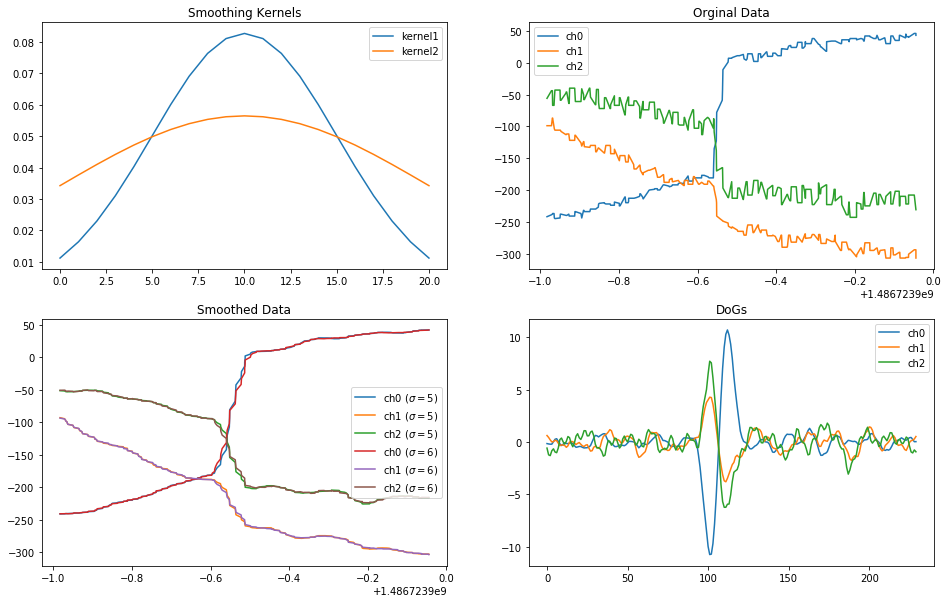

In [13]:
# set up figure
axes = iter(plt.subplots(2,2, figsize=(16, 10))[0].axes)

# get example data window
i = stimulus_idxs[0][9]
w = (-50, 200) 
window = filtered_datasets[0][i+w[0]:i+w[1], :]
eog = window[:, eog_idx]
times = window[:, time_idx]


# set up kernels
size = 21
s1 = 5
s2 = 10

kernel1 = sp.signal.gaussian(size, s1)
kernel1 /= sum(kernel1)
kernel2 = sp.signal.gaussian(size, s2)
kernel2 /= sum(kernel2)


# plot kernels
plt.sca(next(axes))
plt.title('Smoothing Kernels')
plt.plot(kernel1, label='kernel1')
plt.plot(kernel2, label='kernel2')
plt.legend()


# smooth data
smoothed_eog1 = np.apply_along_axis(lambda channel: sp.signal.convolve(channel, kernel1, mode='valid'), 0, eog)
smoothed_eog2 = np.apply_along_axis(lambda channel: sp.signal.convolve(channel, kernel2, mode='valid'), 0, eog)

# smoothing removed border points, remove corresponding ones from original data and timestamps
d = eog.shape[0] - smoothed_eog1.shape[0]
valid_idxs = np.s_[round(d/2):-round(d/2)]
valid_times = times[valid_idxs]
valid_eog = eog[valid_idxs, :]


# plot original data
plt.sca(next(axes))
plt.title('Orginal Data')
lines = plt.plot(valid_times, valid_eog)
channel_names = ['ch{}'.format(i) for i in range(3)]
plt.legend(lines, channel_names)

# plot smoothed data
plt.sca(next(axes))
plt.title('Smoothed Data')
lines1 = plt.plot(valid_times, smoothed_eog1)
lines2 = plt.plot(valid_times, smoothed_eog2)
plt.legend(lines1 + lines2, ['ch{} ($\sigma = {}$)'.format(ch, s) for s in [5,6] for ch in range(3)])


# calculate Difference of Gaussians
dogs = smoothed_eog1 - smoothed_eog2

# plot DoGs
plt.sca(next(axes))
plt.title('DoGs')
lines = plt.plot(dogs)
plt.legend(lines, channel_names)
pass

# Open Questions:
How to find suitable kernel sizes and sigma values? Gotta look into this.

# Finding DoG peaks
As we see in the previous plot, the DoGs show two maximal/minimal peaks at the points where the curves change rapidly. Next we have to find these indices exactly. Looking at the absolute value of the DoGs (below) we see that this might be done through just finding local extrema and sorting them according to they value and taking the biggest two.

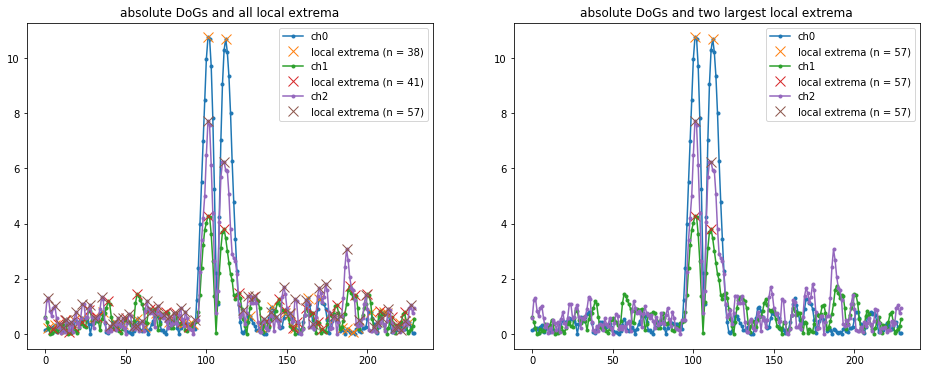

In [14]:
# calculate absolute DoG values
abs_dogs = np.abs(dogs)

# find peaks
peaks = (abs_dogs[:-2,:] < abs_dogs[1:-1,:]) & (abs_dogs[1:-1,:] > abs_dogs[2:,:])
# peak indices start one later, since first datapoint cant be peak, thus add row of False at front and back
peaks = np.vstack((np.zeros((1, peaks.shape[1])),
                   peaks,
                   np.zeros((1, peaks.shape[1]))))

# plot DoGs absolute values and peaks
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.title('absolute DoGs and all local extrema')
for dog_data, peak_data, label in zip(abs_dogs.T, peaks.T, channel_names):
    peak_idxs = peak_data.nonzero()[0]
    plt.plot(dog_data, '.-', label=label)
    plt.plot(peak_idxs, dog_data[peak_idxs], 'x',
             label='local extrema (n = {})'.format(peak_idxs.shape[0]), markersize=10)
plt.legend()


# get sorted dog indices
sorted_dog_idxs = np.argsort(abs_dogs, axis=0)[::-1,:]
# # cols need to be accessed as before, just create indices with range!
# sorted_dogs = abs_dogs[sorted_dog_idxs, range(3)]
# # sort peaks aswell
# sorted_peaks = peaks[sorted_dog_idxs, range(3)]


plt.subplot(122)
plt.title('absolute DoGs and two largest local extrema')

for dog_data, peak_data, sorted_idxs, label in zip(abs_dogs.T, peaks.T, sorted_dog_idxs.T, channel_names):
    # sort the DoGs
    sorted_dogs = dog_data[sorted_idxs]
    
    # for sorted DoGs: are they peaks?
    sorted_peaks = peak_data[sorted_idxs]
    # indices of first two peaks in the sorted DoGs order
    two_peaks_idxs = sorted_peaks.nonzero()[0][:2]
    
    # get x coordinates of two largest peaks through index back-conversion
    two_peaks_x = sorted_idxs[two_peaks_idxs]
    # get y coordinates of two largest peaks
    two_peaks_y = sorted_dogs[two_peaks_idxs]
    
    
    plt.plot(dog_data, '.-', label=label)
    plt.plot(two_peaks_x, two_peaks_y,
             'x', label='local extrema (n = {})'.format(peak_idxs.shape[0]), markersize=10)
plt.legend()

pass

# Next: Wrap finding of DoG peaks into function
Also most of the code can be optimized, if the intermediate things do not need to be plotted...